共计用时0.38s


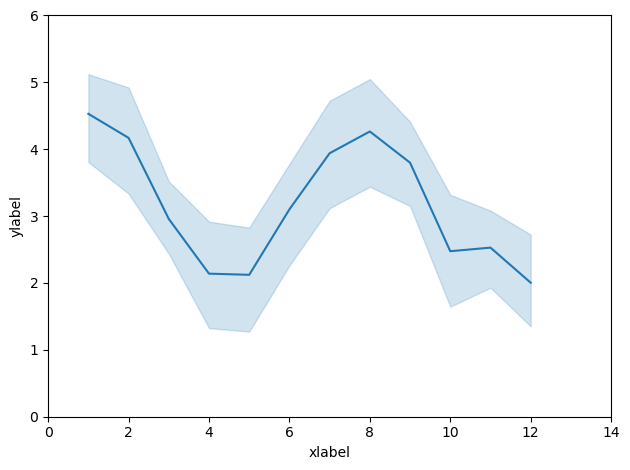

In [1]:
# here put the import lib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

t1 = time.time()

# 构造数据
np.random.seed(1503)
# 构造单一年份数据
x = np.arange(1, 13)
y = np.sin(x)
# 构造十年数据以计算均值和置信区间
year = 10
ys = []
# 利用随机数添加一些误差
for i in range(year):
    ys.append(y + np.random.rand(len(y)) + np.random.randint(1, 5, size=(len(y),)))
ys = np.asarray(ys).reshape(
    -1,
)
xs = x.tolist() * year

fig, ax1 = plt.subplots(1, 1)
sns.lineplot(x=xs, y=ys, ax=ax1)
plt.xlim(0, 14)
plt.xticks(np.arange(0, 15, 2))
plt.ylim(0, 6)
plt.xlabel("xlabel")
plt.ylabel("ylabel")
plt.tight_layout()

t2 = time.time()
print("共计用时{:.2f}s".format(t2 - t1))
plt.show()